In [116]:
import os
from skimage.filters import threshold_otsu
import pandas as pd
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import  tqdm
import trackpy as tp

In [63]:
def remove_disc(_img, r =20, value = 0):
    """
    Remove a disc from an image.

    :param _img: The input image to remove the disc from.
    :param r: The radius of the disc. Default value is 20.
    :param value: The value to set inside the disc. Default value is 0.
    :return: The image with the disc removed.

    Example usage:
        _img = cv2.imread("image.jpg")
        removed_img = remove_disc(_img, r=30, value=255)
    """
    _img = _img.copy()
    # Define the center and radius of the disk
    center = (img.shape[0]//2, _img.shape[1]//2)
    
    # Create index arrays to img
    x = np.arange(0, img.shape[1])
    y = np.arange(0, img.shape[0])

    # Create boolean mask with disk pixel positions set to True
    mask = (x[np.newaxis, :] - center[0]) ** 2 + (y[:, np.newaxis] - center[1]) ** 2 < r ** 2

    # Apply mask to the image
    _img[mask] = value  # or whatever value you wish to set inside the mask
    return _img



In [117]:
DATA_PATH = r'C:\Users\amityu\Gel_Drop_Data'
MOVIE_PATH = os.path.join(DATA_PATH , 'tif_centered')
#MOVIE_PATH = os.path.join(DATA_PATH, 'eye_gel')

# tiff source
#output_dir = r'C:\Users\amityu\Gel_Drop_Data\yuval_clip\\'
output_dir = r'C:\Users\amityu\Gel_Drop_Data\175_950_ex1_clip\\'

files = os.listdir(MOVIE_PATH)
files= sorted(files)
files = files[175:950] #take only relevant files

In [118]:
# read all images
only_quarter = False
img_list = []
for file in tqdm(files):
    img = tifffile.imread(os.path.join(MOVIE_PATH, file))
    if only_quarter:
        img[img.shape[0]//2:,:] = 0
        img[:, img.shape[1]//2:] = 0

    img_list.append(img)
image_array = np.array(img_list)


  0%|          | 0/775 [00:00<?, ?it/s]

In [119]:
#clipping for visualization to adjust image contrast
for file in tqdm(files):
    img = tifffile.imread(os.path.join(MOVIE_PATH, file))
    data = img.flatten()
    data = data[~np.isnan(data)]
    threshold = threshold_otsu(data)
    threshold_data = data[data > threshold]
    threshold2 = np.percentile(threshold_data, 5)
    img=np.clip(img, threshold2, np.percentile(img, 99))
    tifffile.imwrite(os.path.join(output_dir,file), img)
    


  0%|          | 0/775 [00:00<?, ?it/s]

In [4]:
# put crosses in visualization to create ROI for the trackmate plugin to find
# only for exploation purpuses, for production use trackpy
def paint_indices_cross(_img,indices):
    mask = np.zeros_like(_img)
    indices = np.array(indices)
    for j in range(len(indices)):
        x = int(indices[j,1])
        y = int(indices[j,0])
        mask [max(y-1,0):min(y+2, img.shape[0]), x] = 1
        mask[y,max(x-1,0):min(x+2, img.shape[1])] = 1
    return mask

In [120]:
import numpy as np
import scipy.ndimage as ndimage

def find_local_maxima(_image, min_distance=1, q_max  = 0.1):
    """
    :param _image: The input image for finding local maxima.
    :param min_distance: The minimum distance between two local maxima. Defaults to 1.
    :param q_max: The threshold value to filter out low-value peaks. Defaults to 0.1.
    :return: A list of coordinates representing the local maxima.

    """
    # Apply a maximum filter to find local maxima
    neighborhood_size = 2 * min_distance + 1
    local_max = ndimage.maximum_filter(_image, size=neighborhood_size, mode='constant')

    # Compare the original image to the local maxima
    local_maxima = (_image == local_max)

    # Apply a threshold to avoid low-value peaks (optional)
    _threshold = np.nanmax(_image) * q_max
    local_maxima = local_maxima & (_image > _threshold)

    # Label the maxima
    labeled, num_objects = ndimage.label(local_maxima)

    # Find the coordinates of the local maxima
    slices = ndimage.find_objects(labeled)
    _coordinates = [(int(s[0].start + s[0].stop - 1) // 2, int(s[1].start + s[1].stop - 1) // 2) for s in slices]
    
    return _coordinates



In [149]:
output_maxima_dir =r'C:\Users\amityu\Gel_Drop_Data\175_950_ex1_local\\'

In [150]:
## creates images with cross at local maxima for tracking in TRACKMATE
## saves coordinates as a list of coordinates for each time in dataframe of lists
x_list = []
y_list = []
frame_list = []
for i,file in tqdm(enumerate(files)):
    coordinates = find_local_maxima(image_array[i],6)
    #img = paint_indices_cross(image_array[i], coordinates)
    x_list+=[x for (y,x) in coordinates]
    y_list+=[y for (y,x) in coordinates]

    frame_list+=[i]*len(coordinates)
    tifffile.imwrite(os.path.join(output_maxima_dir, file), img)

0it [00:00, ?it/s]

In [155]:

co_df = pd.DataFrame({'frame': frame_list,'y': y_list,'x':x_list})
co_df.to_csv(os.path.join(output_maxima_dir, 'coordinates.csv') )


In [154]:
# save cordinate_df in a format for the tracking gui 
co_df_gui = pd.DataFrame({'FRAME': frame_list,'POSITION_Y': y_list,'POSITION_X':x_list})
co_df_gui.to_csv(os.path.join(output_maxima_dir, 'coordinates_gui.csv') )


In [140]:

def process_tracks(_df, loc_df = None):

    """
    Process tracks in a given DataFrame and return a new DataFrame with collected results.

    :param _df: The DataFrame containing the tracks.
    :param loc_df: Optional DataFrame containing additional location information. The FRAME,x,y of a fixed point in image for registration
    :return: A new DataFrame with the collected results.
    """
    # Group by TRACK_ID
    grouped = _df.groupby('TRACK_ID')

    # Initialize lists to collect results
    track_ids = []
    _frame_list = []
    min_frames = []
    max_frames = []
    min_positions_x = []
    min_positions_y = []
    max_positions_x = []
    max_positions_y = []
    min_angles = []
    max_angles = []
    duration = []
    # Iterate over each group
    for track_id, group in tqdm(grouped):
        min_frame = group['FRAME'].min()
        max_frame = group['FRAME'].max()
        min_frame_row = group[group['FRAME'] == min_frame]
        max_frame_row = group[group['FRAME'] == max_frame]
        min_pos_x = min_frame_row['POSITION_X'].values[0]
        min_pos_y = min_frame_row['POSITION_Y'].values[0]
        max_pos_x = max_frame_row['POSITION_X'].values[0]
        max_pos_y = max_frame_row['POSITION_Y'].values[0]
        if loc_df is not None:
            try:
                # noinspection PyShadowingNames
                x0 = loc_df.loc[loc_df['FRAME']==min_frame, 'x'].values[0]
                # noinspection PyShadowingNames
                y0 = loc_df.loc[loc_df['FRAME']==min_frame, 'y'].values[0]
                x1 = loc_df.loc[loc_df['FRAME']==max_frame, 'x'].values[0]
                # noinspection PyShadowingNames
                y1 = loc_df.loc[loc_df['FRAME']==max_frame, 'y'].values[0]

                

            except Exception as e:
                print(e)
        else:
            x0 = 256
            y0 = 256
            x1 = 256
            y1 = 256
        min_angle = np.degrees(np.arctan2(min_pos_y - y0, min_pos_x - x0))
        max_angle = np.degrees(np.arctan2(max_pos_y - y1, max_pos_x - x1))

        min_angles.append(min_angle)
        max_angles.append(max_angle)

        track_ids.append(track_id)
        min_frames.append(min_frame)
        max_frames.append(max_frame)
        duration.append(max_frame-min_frame)
    
        min_positions_x.append(min_pos_x)
        min_positions_y.append(min_pos_y)
        max_positions_x.append(max_pos_x)
        max_positions_y.append(max_pos_y)
        
    # Create a new DataFrame with the collected results
    _result_df = pd.DataFrame({
        'TRACK_ID': track_ids,
        'MIN_FRAME': min_frames,
        'MAX_FRAME': max_frames,
        'MIN_POSITION_X': min_positions_x,
        'MIN_POSITION_Y': min_positions_y,
        'MAX_POSITION_X': max_positions_x,
        'MAX_POSITION_Y': max_positions_y,
        'MIN_ANGLE': min_angles,
        'MAX_ANGLE': max_angles,
        'DURATION': duration
        
    })

    return _result_df



In [405]:
import pandas as pd

# Perform linkage between frames

tracks = tp.link(co_df, search_range=6,
                 memory=4)  # where search_range is the maximum distance features can move between frames, and memory is the maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle.

# adding stats and saving for gui
# 
trackmate_df = pd.DataFrame({'TRACK_ID':tracks['particle'], 'FRAME': tracks['frame'], 'POSITION_X':tracks['x'], 'POSITION_Y':tracks['y']})
trackmate_df.to_csv(os.path.join(output_maxima_dir,'trackmate.csv'))


Frame 774: 90 trajectories present.


In [406]:
trackmate_df = pd.read_csv(os.path.join(output_maxima_dir,'trackmate.csv'))
#loc_df = pd.read_csv(os.path.join(MOVIE_PATH ,'np/loc.csv'))

result_df = process_tracks(trackmate_df)#, loc_df)  # creating statistics
result_df.to_csv(os.path.join(output_maxima_dir,'tracks.csv'))


  0%|          | 0/39827 [00:00<?, ?it/s]

In [142]:
image_folder = os.path.join(DATA_PATH , r'175_950_ex1_clip')
csv_file = os.path.join(DATA_PATH, os.path.join(output_maxima_dir,'tracks.csv'))
'''tracking_data = pd.read_csv(csv_file, skiprows=[1,2,3])'''

'tracking_data = pd.read_csv(csv_file, skiprows=[1,2,3])'

In [130]:
result_df = pd.read_csv(os.path.join(output_maxima_dir,'tracks.csv'))

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


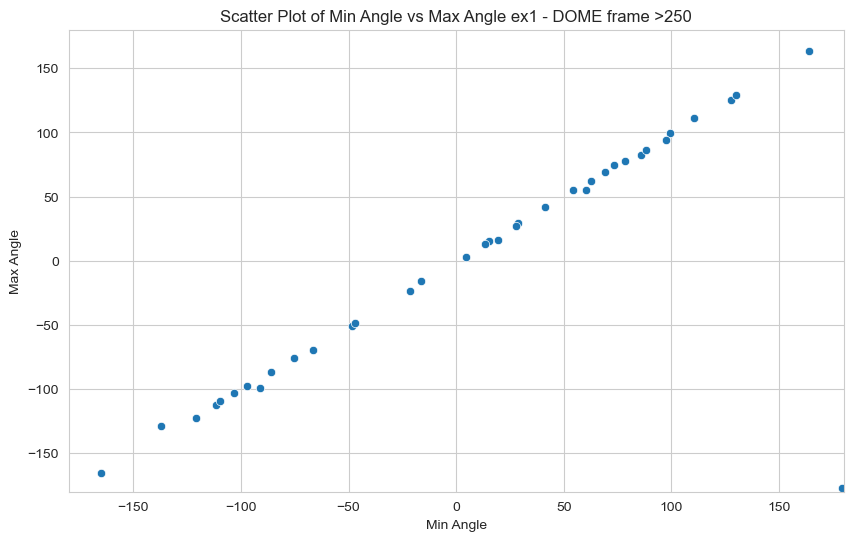

In [158]:

# Angles graph
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MIN_ANGLE', y='MAX_ANGLE', data=result_df[result_df['DURATION']>250])
plt.xlabel('Min Angle')
plt.ylabel('Max Angle')

# Set x and y axis limits 
plt.xlim(-180, 180)
plt.ylim(-180, 180)

plt.title('Scatter Plot of Min Angle vs Max Angle ex1 - DOME frame >250')
plt.show()

In [160]:
loc_df= pd.DataFrame({'FRAME':range(len(image_array)), 'x': [256]*len(image_array), 'y':[256]*len(image_array)})

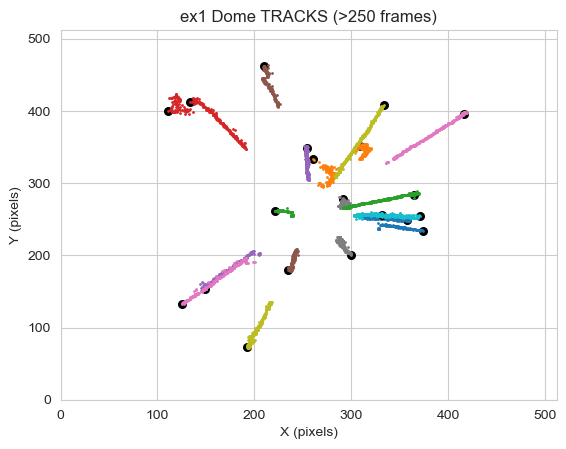

In [463]:

# Plotting the track of particles, compensated for the registration anchor, in loc_df saved in preprocessing file
long_track_id = result_df[result_df['DURATION']>250]['TRACK_ID']
long_track_id = per_track['TRACK_ID']
long_track_id = pd.Series(particle_list)
for track_id in long_track_id.iloc[np.random.randint(0,len(long_track_id), size=20)]:
    track_data = trackmate_df[trackmate_df['TRACK_ID'] == track_id]
    x = []
    y = []
    for idx, row in track_data.iterrows():    
        #x.append(row['POSITION_X'] - (loc_df.loc[loc_df['FRAME'] == row['FRAME'], 'x']-256).values[0])
        #y.append(row['POSITION_Y'] - (loc_df.loc[loc_df['FRAME'] == row['FRAME'], 'y']-256).values[0])
        x.append(row['POSITION_X'])
        y.append(row['POSITION_Y'])
    plt.scatter(result_df[result_df['TRACK_ID'] == track_id]['MIN_POSITION_X'],result_df[result_df['TRACK_ID'] == track_id]['MIN_POSITION_Y'], s=30, c='black')   
    plt.scatter(x,y, label = str(track_id),s=1 )
plt.title('ex1 Dome TRACKS (>250 frames)')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.xlim(0, 512)
plt.ylim(0, 512)

#plt.legend()
plt.show()

In [268]:
per_track = result_df[(np.sqrt((result_df['MIN_POSITION_X'].values - 265)**2 + (result_df['MIN_POSITION_Y'].values - 251)**2 )>100) & (result_df['MIN_FRAME']< 300 ) & (result_df['MIN_FRAME']> 200 ) & (result_df['DURATION']>166) ]
print(len(per_track))

41


In [269]:
print(per_track.describe())

           TRACK_ID   MIN_FRAME   MAX_FRAME  MIN_POSITION_X  MIN_POSITION_Y  \
count     41.000000   41.000000   41.000000       41.000000       41.000000   
mean   26501.902439  250.756098  494.536585      277.560976      252.024390   
std     1662.610700   21.704585  100.454989      118.524058      121.812456   
min    23132.000000  207.000000  394.000000       63.000000       56.000000   
25%    25728.000000  241.000000  429.000000      158.000000      130.000000   
50%    26603.000000  253.000000  461.000000      320.000000      256.000000   
75%    27287.000000  260.000000  513.000000      377.000000      358.000000   
max    30109.000000  299.000000  774.000000      466.000000      437.000000   

       MAX_POSITION_X  MAX_POSITION_Y   MIN_ANGLE   MAX_ANGLE    DURATION  
count       41.000000       41.000000   41.000000   41.000000   41.000000  
mean       267.902439      253.756098    3.346651    4.520317  243.780488  
std         71.929064       75.690085   94.862325   94.52714

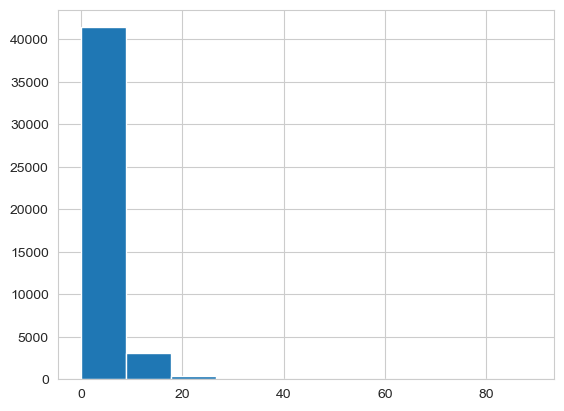

In [198]:
plt.hist(per_track['DURATION'])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def center_of_contraction(positions, vectors):
    # Extract x, y positions and u, v vector components
    x, y = zip(*positions)
    u, v = zip(*vectors)

    # Convert to numpy arrays
    x = np.array(x)
    y = np.array(y)
    u = np.array(u)
    v = np.array(v)

    # Calculate magnitudes of vectors
    magnitudes = np.sqrt(u**2 + v**2)

    # Calculate the weighted average of positions
    x_center = np.sum(x * magnitudes) / np.sum(magnitudes)
    y_center = np.sum(y * magnitudes) / np.sum(magnitudes)

    return y_center, x_center

# Example usage
positions = [(1, 7), (2, 6), (5, 8), (7, 7), (9, 6)]
vectors = [(-1, -1), (-1, -1), (-2, -2), (-1, -1), (-1, -1)]

y_center, x_center = center_of_contraction(positions, vectors)
print(f"Center of contraction: ({x_center}, {y_center})")

# Visualization
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Plot the original points and vectors
for (x, y), (u, v) in zip(positions, vectors):
    ax.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='blue')

# Plot the center of contraction
ax.plot(x_center, y_center, 'ro', label='Center of contraction')

# Set plot limits
buffer = 1
ax.set_xlim(min(x) - buffer, max(x) + buffer)
ax.set_ylim(min(y) - buffer, max(y) + buffer)

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_title('Center of Contraction')

plt.show()

In [72]:
result_df['SIGN'] = np.sign(result_df['MIN_ANGLE'] * result_df['MAX_ANGLE'])


In [79]:
result_df.head()


,TRACK_ID,MIN_FRAME,MAX_FRAME,MIN_POSITION_X,MIN_POSITION_Y,MAX_POSITION_X,MAX_POSITION_Y,MIN_ANGLE,MAX_ANGLE,DURATION,SIGN
0,0,0,12,29,0,27,2,-134.333800,-147.855634,12,1.0
1,1,0,32,70,335,65,332,-177.510447,114.897665,32,-1.0
2,2,0,10,50,335,52,335,-177.666354,117.135140,10,-1.0
3,3,0,5,355,334,352,334,-135.000000,53.476878,5,-1.0
4,4,0,19,60,334,57,333,-177.405849,116.372137,19,-1.0


In [407]:
x = result_df['DURATION'].values

In [171]:
import numpy as np
from scipy.optimize import least_squares

def circle_residuals(params, x, y):
    xc, yc, r = params
    return np.sqrt((x - xc)**2 + (y - yc)**2) - r

def fit_circle(x, y):
    # Initial guess for circle parameters (x_center, y_center, radius)
    x_m = np.mean(x)
    y_m = np.mean(y)
    r_guess = np.sqrt(np.mean((x - x_m)**2 + (y - y_m)**2))
    initial_guess = [x_m, y_m, r_guess]

    # Optimize the parameters to minimize the residuals
    result = least_squares(circle_residuals, initial_guess, args=(x, y))
    xc, yc, r = result.x

    return int(yc), int(xc), np.round(r,2)

# Example usage
coordinates = [(1, 7), (2, 6), (5, 8), (7, 7), (9, 6)]
x, y = zip(*coordinates)

%time y_center, x_center, radius = fit_circle(np.array(x), np.array(y))
print(f"Circle center: ({x_center}, {y_center}), Radius: {radius}")


CPU times: total: 0 ns
Wall time: 3.68 ms
Circle center: (4, 2), Radius: 5.47


Circle center: (4.882781647847784, 2.253668497714227), Radius: 5.474099214202387


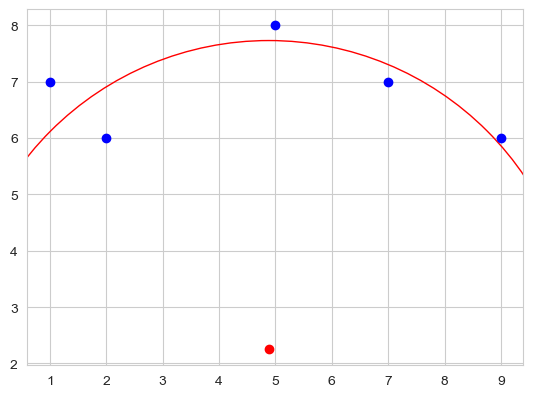

In [163]:
y_center, x_center, radius = fit_circle(np.array(x), np.array(y))
print(f"Circle center: ({x_center}, {y_center}), Radius: {radius}")

# Visualization
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Plot the original points
ax.plot(x, y, 'bo', label='Data points')

# Plot the fitted circle
circle = plt.Circle((x_center, y_center), radius, color='r', fill=False, label='Fitted circle')
ax.add_artist(circle)

# Plot the center of the circle
ax.plot(x_center, y_center, 'ro', label='Circle center')


In [388]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Step 1: Load particle tracks
# Example data: particle_id, time, x, y
data = tracks

# Step 2: Calculate velocities
data['vx'] = data.groupby('particle')['x'].diff() / data.groupby('particle')['frame'].diff()
data['vy'] = data.groupby('particle')['y'].diff() / data.groupby('particle')['frame'].diff()

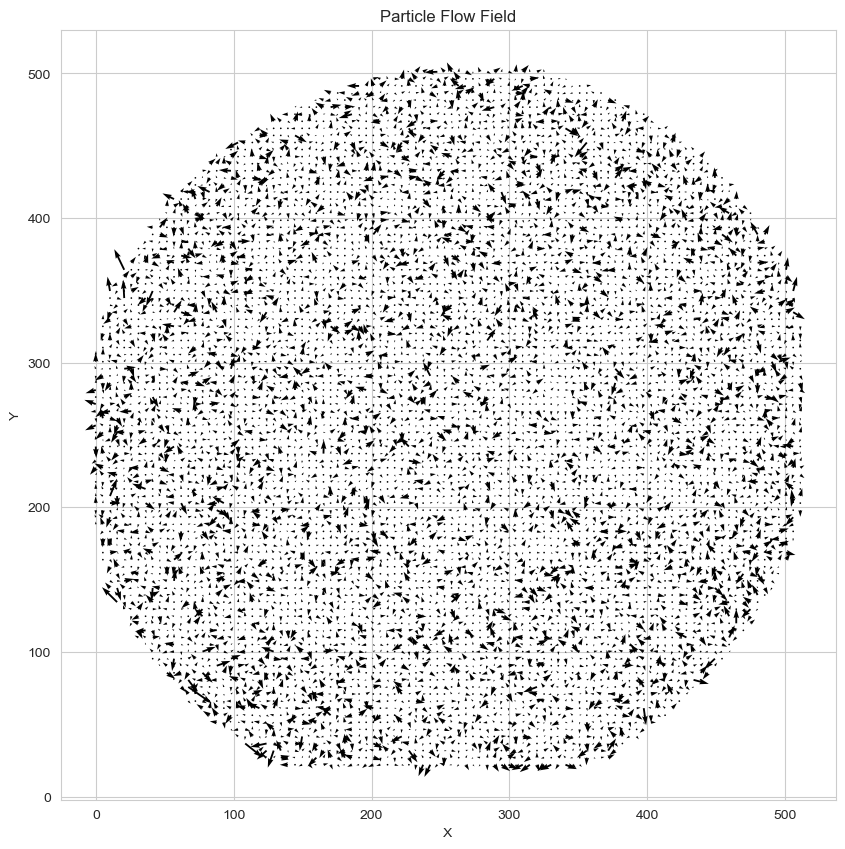

In [271]:

# Drop rows with NaN values (first time step for each particle)
data = data.dropna()

# Step 3: Interpolate velocity field onto a grid
grid_x, grid_y = np.mgrid[data['x'].min():data['x'].max():100j, data['y'].min():data['y'].max():100j]
points = data[['x', 'y']].values
values_vx = data['vx'].values
values_vy = data['vy'].values

grid_vx = griddata(points, values_vx, (grid_x, grid_y), method='cubic')
grid_vy = griddata(points, values_vy, (grid_x, grid_y), method='cubic')

# Step 4: Visualize the flow field
plt.figure(figsize=(10, 10))
plt.quiver(grid_x, grid_y, grid_vx, grid_vy)
plt.title('Particle Flow Field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [273]:
tracks_by_time = [tracks[(tracks['frame']>  t0) & (tracks['frame']<  t0 + 15) ] for t0 in range(0, len(tracks),15)]

In [408]:
flag = False
if flag:
    
    track_bu = tracks.copy()

In [536]:
tracks = track_bu.copy()
len(tracks)

458620

In [537]:
particle_list = result_df[result_df['DURATION']>20]['TRACK_ID'].unique()
print(len(particle_list))

12146


In [538]:
tracks = tracks[tracks['particle'].isin(particle_list)]
len(tracks)

338348

In [539]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

tracks.sort_values(by = ['particle','frame'], inplace=True)

for particle in tracks['particle'].unique():
    mask = tracks['particle'] == particle
    dx = tracks.loc[mask]['x'].diff()
    tracks.loc[mask,'dx'] = dx
    dy = tracks.loc[mask]['y'].diff()
    tracks.loc[mask,'dy'] = dy


In [540]:
tracks = tracks.dropna()

1 303


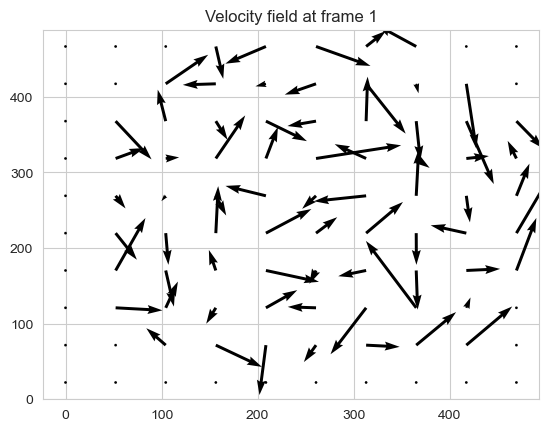

51 818


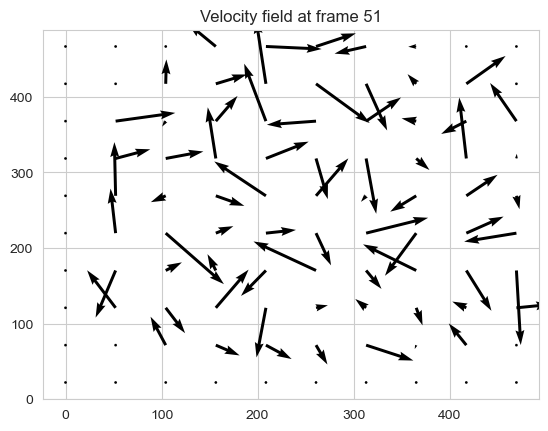

101 847


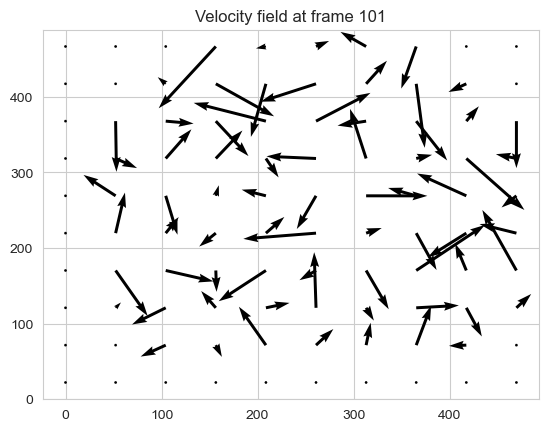

151 781


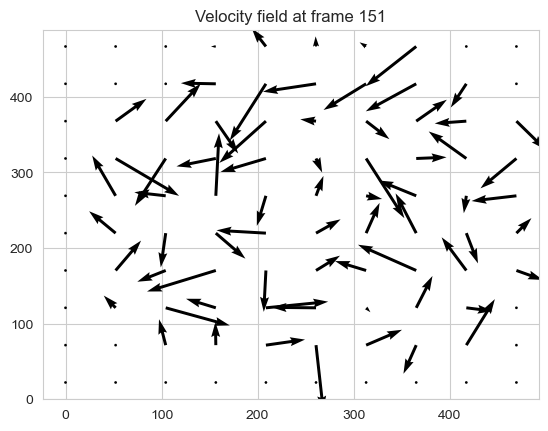

201 619


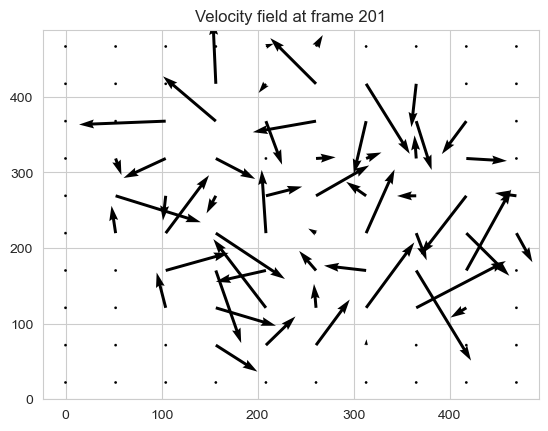

251 605


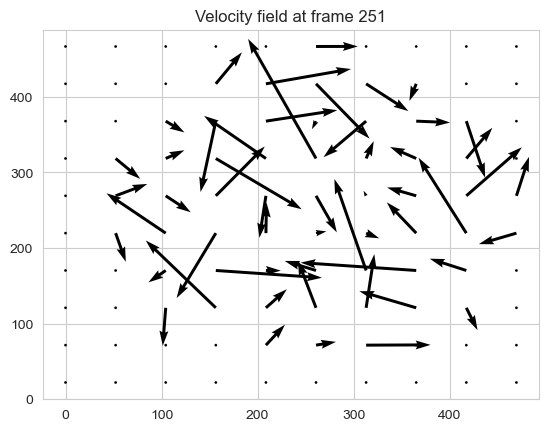

301 567


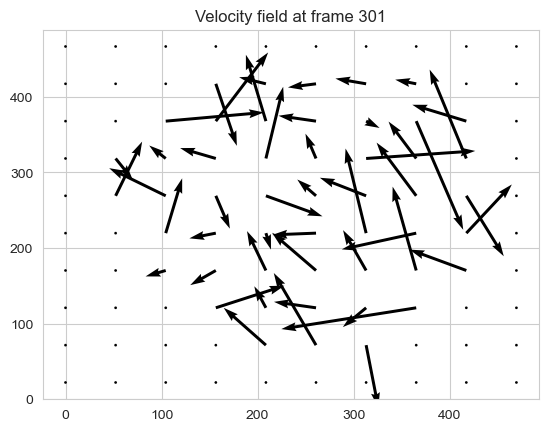

351 451


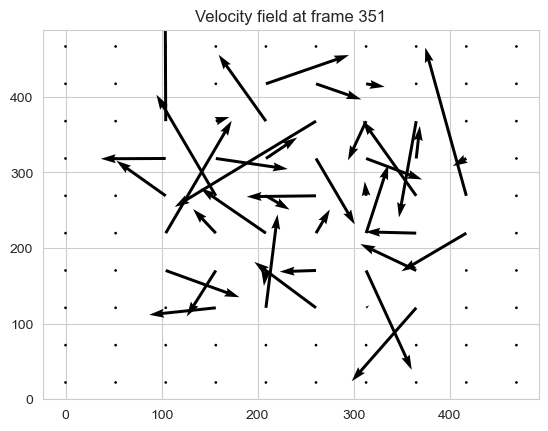

401 365


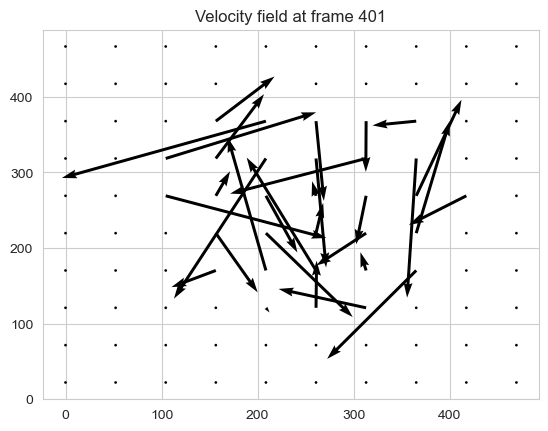

451 300


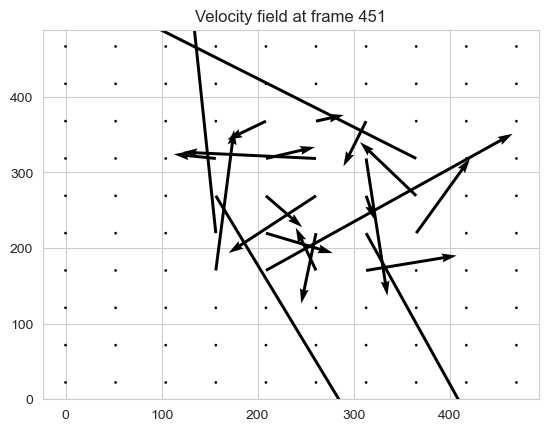

501 239


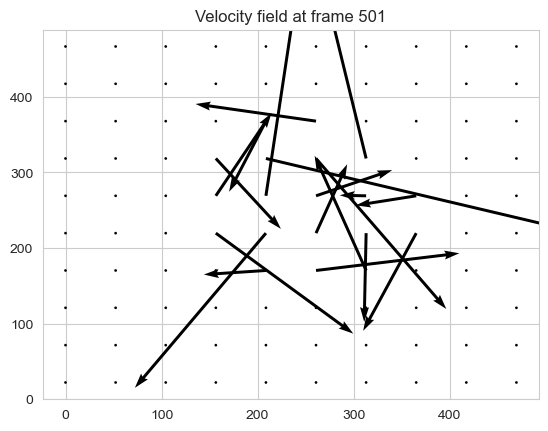

551 185


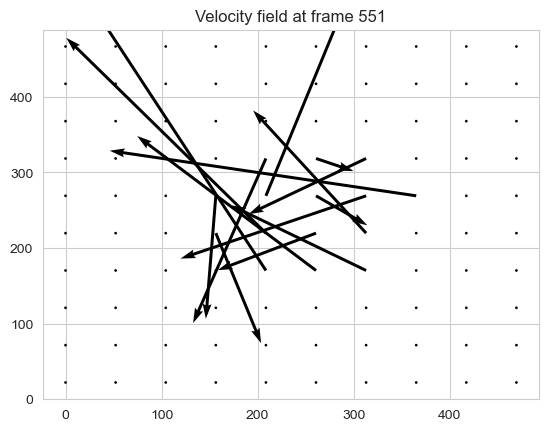

601 154


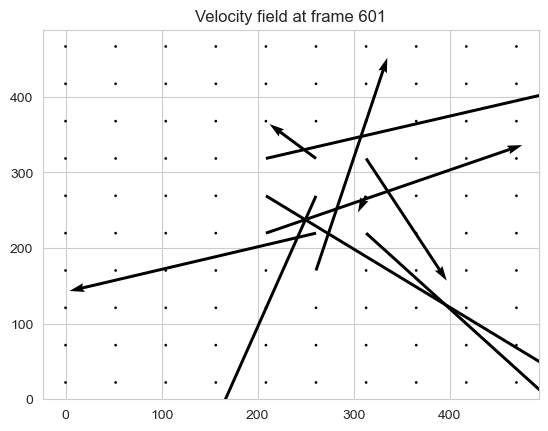

651 114


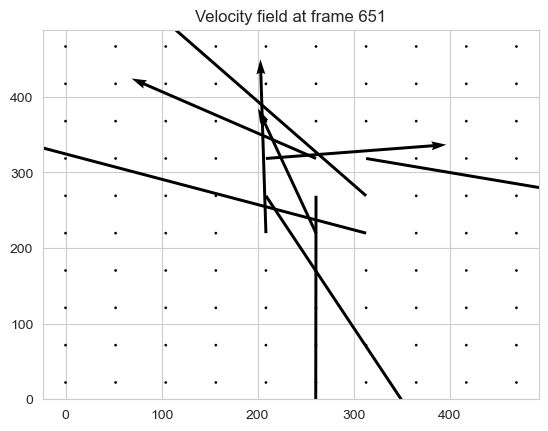

701 94


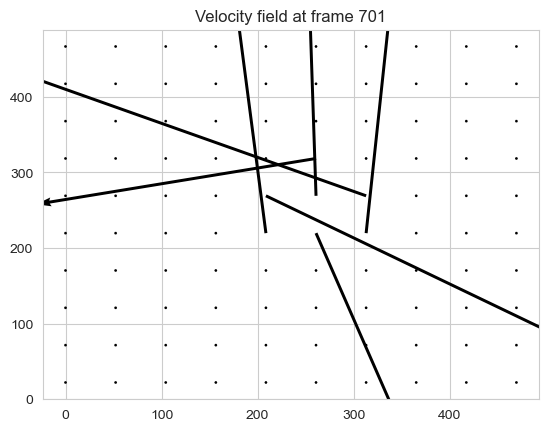

751 82


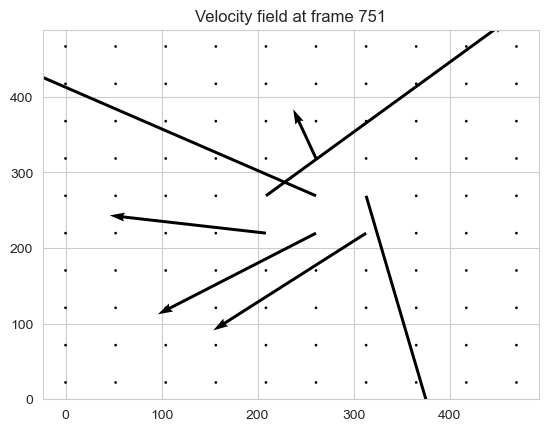

In [541]:

# Remove NANs produced by the diff() operation
tracks = tracks.dropna()

# Get the range of 'x' and 'y' over all particles and all frames
x_range = np.min(tracks['x']), np.max(tracks['x'])
y_range = np.min(tracks['y']), np.max(tracks['y'])

# Calculate one 2D velocity field map per frame
for frame in range(1,tracks['frame'].max(),50):# tracks['frame'].unique():
    frame_data = tracks[tracks['frame'] == frame]
    print(frame, len(frame_data))
    if len(frame_data)<4:
        continue
    # Create grid of x and y values
    grid_x, grid_y = np.mgrid[x_range[0]:x_range[1]:50j, y_range[0]:y_range[1]:50j]

    # Perform 2D interpolation
    grid_u = griddata(frame_data[['x', 'y']].values, frame_data['dx'].values, (grid_x, grid_y), method='cubic',
                      fill_value=0)
    grid_v = griddata(frame_data[['x', 'y']].values, frame_data['dy'].values, (grid_x, grid_y), method='cubic',
                      fill_value=0)

    # Plot the velocity field
    plt.figure()
    #plt.quiver(grid_x, grid_y, grid_u, grid_v)
    skip = (slice(None, None, 5), slice(None, None, 5)) 
    plt.quiver( grid_x[skip], grid_y[skip], grid_u[skip], grid_v[skip])
    #plt.streamplot(grid_x, grid_y, grid_u, grid_v)
    plt.title('Velocity field at frame %d' % frame)
    plt.show()

In [323]:
frame_data[['x', 'y']].values

array([[274, 247],
       [293, 266],
       [246, 246],
       [310, 306],
       [284, 311],
       [270, 322],
       [304, 215],
       [233, 271],
       [257, 271],
       [291, 258],
       [255, 307],
       [239, 190],
       [237, 260],
       [218, 230],
       [275, 210],
       [288, 225],
       [230, 218],
       [259, 202],
       [268, 313],
       [311, 229],
       [276, 286],
       [238, 324],
       [292, 294]], dtype=int64)

In [523]:
print(tracks.describe())

               frame              y              x       particle  \
count  418793.000000  418793.000000  418793.000000  418793.000000   
mean      239.731567     256.641895     256.866669   20185.264450   
std       177.598076     106.820002     111.936483   11534.489993   
min         1.000000      22.000000       0.000000       0.000000   
25%        96.000000     177.000000     174.000000   10162.000000   
50%       205.000000     257.000000     257.000000   20553.000000   
75%       345.000000     336.000000     340.000000   30123.000000   
max       774.000000     506.000000     511.000000   39818.000000   

                  dx             dy  
count  418793.000000  418793.000000  
mean       -0.003188       0.003522  
std         2.213974       2.221581  
min        -6.000000      -6.000000  
25%        -1.000000      -1.000000  
50%         0.000000       0.000000  
75%         1.000000       1.000000  
max         6.000000       6.000000  


In [367]:
tracks.head()

,frame,y,x,particle,dx,dy
157385,129,324,155,16368,NaN,NaN
158590,130,327,160,16368,5.0,3.0
159833,131,327,157,16368,-3.0,0.0
159091,131,65,108,16661,NaN,NaN
163416,134,324,161,16368,4.0,-3.0


-67.0


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


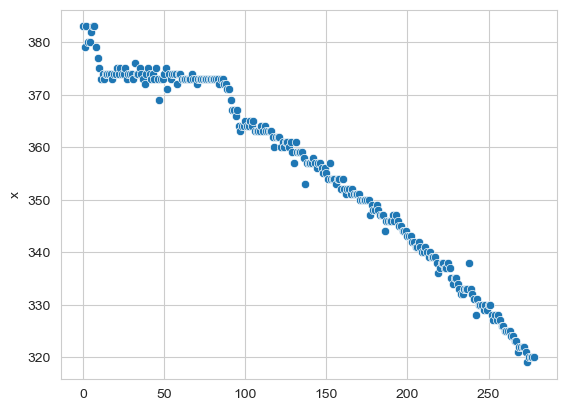

In [512]:
one_track = tracks[tracks['particle']==wrong_particle[10]]
len(one_track)
#sns.scatterplot(data =one_track, x='x', y='y')
#sns.scatterplot(data=one_track.iloc[:1], x='x', y='y', c = 'red')
#sns.lineplot(data =one_track, x='x', y='y')
sns.scatterplot(data =one_track, x=range(len(one_track)), y='x')
print(one_track.dx.sum())


In [514]:
tracks = tracks.dropna()
tracks_no_zero = tracks[tracks.dx!=0]
sign_check = np.sign(tracks_no_zero['dx'].values) == np.sign(256 - tracks_no_zero['x'].values)

#tracks = tracks[~sign_check]
print(sign_check.sum()/len(sign_check))


0.5706973768394114


In [470]:
wrong_particle = tracks.particle.unique()

In [431]:
print(tracks.describe())

              frame             y             x      particle            dx
count  27904.000000  27904.000000  27904.000000  27904.000000  27904.000000
mean     470.528419    258.919474    266.842137  28983.024477     -0.023258
std      151.999833     68.773832     64.078488   7664.475045      1.312072
min       24.000000     40.000000     57.000000   4646.000000     -6.000000
25%      358.000000    213.000000    229.000000  24725.000000     -1.000000
50%      478.000000    259.000000    269.000000  31712.000000      0.000000
75%      587.000000    308.000000    310.000000  35434.000000      1.000000
max      774.000000    463.000000    465.000000  38275.000000      6.000000
